<font color='blue'>Снова привет! Поздравляю со вторым выполненным проектом. Вторая работа еще объемнее первой. Я проверю твою работу и напишу свои комментарии. Они, в зависимости от результата проверки, будут в </font><font color='green'>зеленом (когда все отлично),</font> <font color='brown'>коричневом (когда можно лучше)</font><font color='blue'> или</font> <font color='red'>красном (когда нужно переделать, чтобы я принял работу).</font><font color='blue'> Постарайся учесть эти комментарии в дальнейших проектах.</font>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [3]:
len(df)

23699

###### Сколько значений пропущено в каждой колонке?

In [4]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                'percent_missing': percent_missing})
missing_value_df.sort_values(by='percent_missing').round(2)

,column_name,percent_missing
total_images,total_images,0.00
open_plan,open_plan,0.00
floor,floor,0.00
rooms,rooms,0.00
studio,studio,0.00
total_area,total_area,0.00
last_price,last_price,0.00
first_day_exposition,first_day_exposition,0.00
locality_name,locality_name,0.21
floors_total,floors_total,0.36


### Вывод

##### 1. где есть пропущенные значения

+ceiling_height — не указана высота потолка. Заполним медианными значениями высот потолков в домах такой же этажности.

kitchen_area — Пропущено всего 10%   
living_area,  пропущена — оставить как есть. 
is_apartment — оставим как есть

+balcony — дополним false (0)

airports_nearest, cityCenters_nearest, parks_around3000, ponds_nearest — эти параметры в задании не используются, ничего делать не будем. Хотя они подозрительно одинаково парно пропущены

days_exposition — оставить как есть, дополнять нечем. Пропущено всего 13%

<s><font color='red'>+Пожалуйста, удали пропуски там, где это не сильно повлияет на данные. Используй метод fillna().</font>

<font color='green'> Удалил!

In [5]:
# zerro_names = ['ponds_around3000', 'parks_around3000', 'floors_total', 'balcony', 'living_area', 'kitchen_area']
# zerro_names = ['balcony']

# for name in zerro_names:
#     df[name] = df[name].fillna(0)

# df[['locality_name','floors_total']].dropna(inplace = True)
# df.reset_index(drop=True)

# df.query(df.fillna().dropna(inplace=True).reset_index(drop=True)

df = df.dropna(how='any', subset=['locality_name', 'floors_total'])
df['balcony'] = df['balcony'].fillna(0)


percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                'percent_missing': percent_missing})
print(missing_value_df.sort_values(by='percent_missing').round(2))

                               column_name  percent_missing
total_images                  total_images             0.00
locality_name                locality_name             0.00
balcony                            balcony             0.00
open_plan                        open_plan             0.00
floor                                floor             0.00
floors_total                  floors_total             0.00
studio                              studio             0.00
rooms                                rooms             0.00
first_day_exposition  first_day_exposition             0.00
total_area                      total_area             0.00
last_price                      last_price             0.00
living_area                    living_area             7.91
kitchen_area                  kitchen_area             9.43
days_exposition            days_exposition            13.46
parks_around3000          parks_around3000            23.34
ponds_around3000          ponds_around30

<s><b><font color='red'>Ты меня немного не так понял, я имел в виду просто удалить строки, где нет названия населенного пункта и количества этажей. Они составляют меньше процента датасета, так что мы не потеряем много данных. А заменять отсутствующие значения вроде площади кухни или высоты дома на нули как раз нельзя, это исказит наш анализ. Для подобной замены нужно лигичное обоснование, как, наприер, с балконами. </font>  
<font color='green'>Ага, убрал! Только я не понял, зачем для этого использовать fillNA — ведь это заполнение?  
    <b><font color='blue'>Описка, приношу извинения. Но ты понял, что я имел в виду. :)

<s><font color='red'> Если ты хотел убрать из датасета строки, где нет данных по количеству этажей, нужно применять dropna ко всему сету, указав в параметрах столбцы, в которых ищешь Na.</s>

<font color='green'>    Вроде разобрался, спасибо!

##### 2. Какие данные нужно изменить

+++last_price, ceiling_height, floors_total, floor, days_exposition airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, balcony// int   

+++ first_day_exposition // to date  

is_apartment // bool  

+++locality_name // str.lower()


### Шаг 2. Предобработка данных

###### Сделаем столбцы целочисленными

In [6]:
int_columns = ('balcony, last_price, ceiling_height, floors_total, floor, days_exposition, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest')
               
int_columns = int_columns.split(', ')
for column in int_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce', downcast='integer')
    
df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null int32
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          14481 non-null float64
floors_total            23565 non-null int8
living_area             21700 non-null float64
floor                   23565 non-null int8
is_apartment            2760 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            21343 non-null float64
balcony                 23565 non-null int8
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000        

<s><font color='red'>Тип поменялся только у полей без пропусков. Попробуй другой метод.</font>  
<font color='green'> Но ведь у NAN значение float — его не получится изменить, насколько я понял.

<font color='blue'>+Давай действовать так: удалим строки с немногочисленными пропущенными значениями, после чего у нас не останется пропусков в ключевых полях, далее, заменим в них тип данных на целочисленный. Не будем этого делать в оставшизся полях с пропусками.</font>

###### first_day_exposition // to date  


<font color='green'>Молодец, что использовал цикл.</font>

In [7]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
df['first_day_exposition'].head()


0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

###### Недвижимость в строковый форма и lowercase


In [8]:
df['locality_name'] = df['locality_name'].astype('str').str.lower()

In [9]:
df.pivot_table(index ='locality_name', aggfunc=('count', 'mean'))


airports_nearest      balcony           ceiling_height  \
                         count mean   count      mean          count   
locality_name                                                          
бокситогорск                 0  NaN    16.0  0.187500              2   
волосово                     0  NaN    36.0  0.750000             19   
волхов                       0  NaN   111.0  0.351351             58   
всеволожск                   0  NaN   398.0  0.721106            272   
выборг                       0  NaN   237.0  0.354430             98   
...                        ...  ...     ...       ...            ...   
сосновый бор                 0  NaN    87.0  0.804598             51   
сясьстрой                    0  NaN    24.0  0.791667             10   
тихвин                       0  NaN    49.0  0.836735             11   
тосно                        0  NaN   104.0  0.817308             70   
шлиссельбург                 0  NaN    57.0  0.614035             41   

                        cityCenters_nearest      days_exposition              \
                   mean               count mean           count        mean   
locality_name                                                                  
бокситогорск   3.900000                   0  NaN              14   89.571429   
волосово       2.531579                   0  NaN              31  279.516129   
волхов         3.151207                   0  NaN              85  152.400000   
всеволожск     2.675625                   0  NaN             339  197.085546   
выборг         2.728776                   0  NaN             208  177.375000   
...                 ...                 ...  ...             ...         ...   
сосновый бор   2.570784                   0  NaN              74   99.594595   
сясьстрой      2.565000                   0  NaN              17  154.647059   
тихвин         2.610909                   0  NaN              40   94.575000   
тосно          2.542286                   0  NaN              94  160.553191   
шлиссельбург   2.589024                   0  NaN              45  211.688889   

               ... ponds_nearest       rooms           studio            \
               ...         count mean  count      mean  count      mean   
locality_name  ...                                                        
бокситогорск   ...             0  NaN   16.0  2.125000     16  0.000000   
волосово       ...             0  NaN   36.0  1.916667     36  0.000000   
волхов         ...             0  NaN  111.0  1.990991    111  0.000000   
всеволожск     ...             0  NaN  398.0  1.914573    398  0.015075   
выборг         ...             0  NaN  237.0  2.122363    237  0.000000   
...            ...           ...  ...    ...       ...    ...       ...   
сосновый бор   ...             0  NaN   87.0  2.183908     87  0.000000   
сясьстрой      ...             0  NaN   24.0  2.083333     24  0.000000   
тихвин         ...             0  NaN   49.0  2.061224     49  0.000000   
тосно          ...             0  NaN  104.0  2.144231    104  0.009615   
шлиссельбург   ...             0  NaN   57.0  1.964912     57  0.000000   

              total_area            total_images             
                   count       mean        count       mean  
locality_name                                                
бокситогорск          16  48.075000         16.0   7.625000  
волосово              36  50.184722         36.0   8.333333  
волхов               111  49.655856        111.0   8.522523  
всеволожск           398  56.022186        398.0  10.253769  
выборг               237  56.150042        237.0   9.679325  
...                  ...        ...          ...        ...  
сосновый бор          87  52.726437         87.0  12.459770  
сясьстрой             24  47.591667         24.0   8.500000  
тихвин                49  49.694898         49.0   6.326531  
тосно                104  54.388750        104.0   8.951923  
шлиссельбург          57  5

<s><font color='red'> Давай все же что-то сделаем с высотой потолков. Например, предположим, что у всех домов одинаковой этажности потолки примерно одинаковой высоты и заполним поле медианными значениями в соответствии с этажностью дома.  
    Также я хотел бы увидеть гипотезы насчет появления пропусков и рассуждения по поводу их случайности/неслучайности.
    
<font color='green'> Явно пропуски в геолокационных данных связаны с ошибкой выгрузки — мы всегда знаем адрес квартиры и карты существуют. Поскольку данные сформированы автоматически — кто-то ошибся при выгрузке.

заполним поле медианными значениями в соответствии с этажностью дома

In [10]:
df.groupby('floors_total')['ceiling_height'].agg(['count', 'mean', 'median'])

,count,mean,median
floors_total,,,
1,10,2.740000,2.80
2,213,3.008028,2.70
3,399,2.969474,2.80
4,787,2.985909,3.00
5,3662,2.792865,2.55
6,618,3.121343,3.00
7,397,2.946322,3.00
8,219,2.856164,2.80
9,2557,2.599093,2.55


Сравнивая медиану и среднюю в группах по этажности дома явно видны две проблемы — нет 33-го этажа вообще и в 36-этажном явно завышенные значения 

In [11]:
df.query('floors_total == (33, 36)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
397,15,5990000,54.0,2018-03-22,2,NaN,36,21.4,28,NaN,...,18.7,1,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,11.0
5807,17,8150000,80.0,2019-01-09,2,27.0,36,41.0,13,NaN,...,12.0,5,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
11079,16,9200000,75.0,2019-02-22,2,2.7,36,40.0,29,NaN,...,12.0,2,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,NaN
11575,9,9900000,101.0,2016-04-28,3,NaN,33,53.0,32,False,...,21.0,0,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,53.0


In [12]:
df.query('floors_total == (33, 36)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
397,15,5990000,54.0,2018-03-22,2,NaN,36,21.4,28,NaN,...,18.7,1,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,11.0
5807,17,8150000,80.0,2019-01-09,2,27.0,36,41.0,13,NaN,...,12.0,5,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
11079,16,9200000,75.0,2019-02-22,2,2.7,36,40.0,29,NaN,...,12.0,2,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,NaN
11575,9,9900000,101.0,2016-04-28,3,NaN,33,53.0,32,False,...,21.0,0,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,53.0


Похоже у нас только одно объявление с 33 этажным домом. Удалим его.

In [13]:
df = df[df.floors_total != 33]

In [14]:
df = df[df.ceiling_height != 100]

Удалим высоту больше 100. Поправим высоту потолка везде где 27 на 2.7 — понятно что ошиблись при вводе.

In [15]:
len(df)

23563

In [16]:
def change_parametr(raw):
    if raw == 27:
        return 2.7
    return raw
    
df['ceiling_height'] = df['ceiling_height'].apply(change_parametr)
df[df['ceiling_height'] == 27]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [17]:
df.groupby('floors_total')['ceiling_height'].agg(['count', 'mean', 'median'])

,count,mean,median
floors_total,,,
1,10,2.740000,2.80
2,213,2.779859,2.70
3,399,2.969474,2.80
4,787,2.955032,3.00
5,3661,2.753037,2.55
6,618,3.121343,3.00
7,397,2.946322,3.00
8,219,2.856164,2.80
9,2557,2.599093,2.55


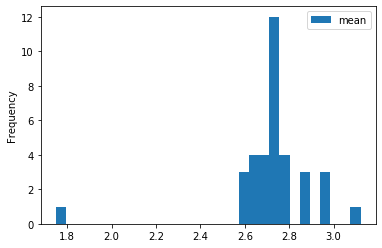

In [18]:
df.groupby('floors_total')['ceiling_height'].agg(['count', 'mean', 'median']).plot(kind='hist', bins=30, x='count', y='mean')

In [19]:
# df['ceiling_height'] = df.groupby('floors_total')['ceiling_height'].transform(lambda x: x.fillna(x.mean()))
# не сработало, так как в столбце 'floors_total' были пропуски.
df['ceiling_height'] = df.groupby('floors_total')['ceiling_height'].apply(lambda x: x.fillna(x.mean()))

In [20]:
df['ceiling_height'].isnull().sum()

0

In [21]:
df[df['ceiling_height'] <2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5712,5,1500000,42.8,2017-08-14,2,1.20,2,27.5,1,NaN,...,5.20,0,городской посёлок мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000,40.0,2017-10-17,1,1.75,37,17.4,5,NaN,...,8.34,0,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
22590,16,6000000,55.0,2018-10-31,2,1.00,12,32.4,7,NaN,...,10.00,0,санкт-петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0


Три значения меньше 2 метров удалим

In [22]:
df = df[df['ceiling_height'] >2]
df[df['ceiling_height'] <2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [23]:
len(df)

23549

Похоже удалили не очень много!

<font color='green'>Хорошо, пропуски заполнили, данных потеряли минимум.</font>

### Шаг 3. Посчитайте и добавьте в таблицу

цену квадратного метра;  
день недели, месяц и год публикации объявления;  
этаж квартиры; варианты — первый, последний, другой;  
соотношение жилой и общей площади, а также отношение площади кухни к общей.


###### Цена квадратного метра

In [24]:
df['sq_meter_cost'] = df['last_price'] / df['total_area']

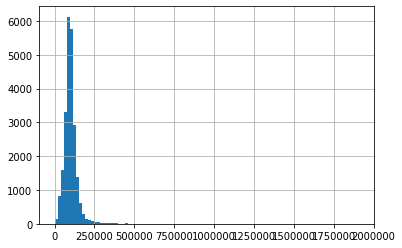

In [25]:
df['sq_meter_cost'].hist(bins=100)

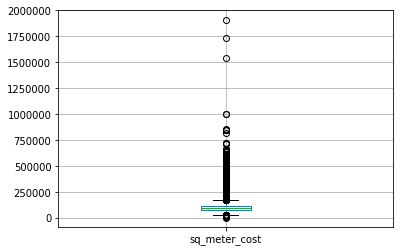

In [26]:
df.boxplot(column='sq_meter_cost')

In [27]:
len(df[df['sq_meter_cost']>750000])

10

Удалим единичные значения стоимости выше 750 тысяч

In [28]:
len(df)

23549

In [29]:
df = df[df.sq_meter_cost < 750000]
len(df)

23539

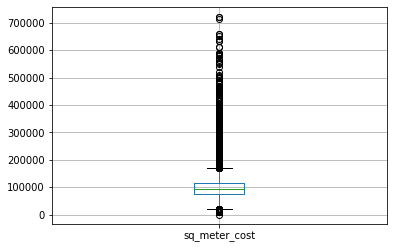

In [30]:
df.boxplot(column='sq_meter_cost')

<font color='green'>Хорошо, но вообще график нам показывает, что выбросы начинаются уже около 200 000</font>

###### День недели, месяц и год публикации объявления;  
    

In [31]:
# def show_date(column):
    
# pd.DatetimeIndex(arrivals['date']).month

df['Year'] = pd.DatetimeIndex(df['first_day_exposition']).year
df['Day'] = pd.DatetimeIndex(df['first_day_exposition']).day
df['weekday'] = pd.DatetimeIndex(df['first_day_exposition']).weekday
df['Month'] = pd.DatetimeIndex(df['first_day_exposition']).month

###### Группировка этажа квартиры; варианты — первый, последний, другой;  


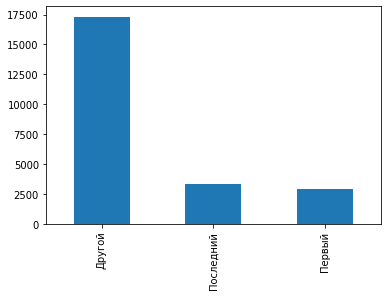

In [32]:
def floor_group(string):
    if string['floor'] == string['floors_total']:
        return 'Последний'
    elif string['floor'] == 1:
        return 'Первый'
    return 'Другой'

df['floor_group'] = df.apply(floor_group, axis = 1)
df['floor_group'].value_counts().plot(kind='bar')

###### Cоотношение жилой и общей площади, а также отношение площади кухни к общей.


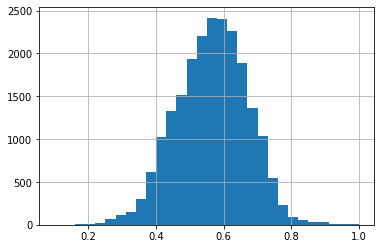

In [33]:
df['living_vs_total_area'] = df['living_area'] / df['total_area']
df['living_vs_total_area'].hist(bins=30, range=(0.1, 1))

Соотношение стремится к 0.5 — половина жилья — жилая. Выбросы на нуле — последствия заполнения пропусков нулями, уберу с помощью range

In [34]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,Year,Day,weekday,Month,floor_group,living_vs_total_area
0,20,13000000,108.0,2019-03-07,3,2.700000,16,51.0,8,NaN,...,2.0,755.0,NaN,120370.370370,2019,7,3,3,Другой,0.472222
1,7,3350000,40.4,2018-12-04,1,2.782385,11,18.6,1,NaN,...,0.0,NaN,81.0,82920.792079,2018,4,1,12,Первый,0.460396
2,10,5196000,56.0,2015-08-20,2,2.753037,5,34.3,4,NaN,...,2.0,574.0,558.0,92785.714286,2015,20,3,8,Другой,0.612500
3,0,64900000,159.0,2015-07-24,3,2.731545,14,NaN,9,NaN,...,3.0,234.0,424.0,408176.100629,2015,24,4,7,Другой,NaN
4,2,10000000,100.0,2018-06-19,2,3.030000,14,32.0,13,NaN,...,1.0,48.0,121.0,100000.000000,2018,19,1,6,Другой,0.320000


### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

###### Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.


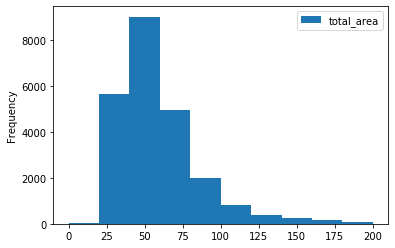

In [35]:
# parametr = ['total_area', 'last_price', 'rooms', 'ceiling_height']
# for name in parametr:
#     df[name].plot(kind='hist', label = name, legend=True)
#     plt.show()

# df['total_area'].plot(kind='hist', range=(0,200), label = 'total_area', bins = 10, legend=True)
# plt.show()
# df.pivot_table(index=['rooms'], values =['total_area', 'last_price', 'ceiling_height'], aggfunc =['count', 'mean', 'min', 'max'])

df['total_area'].plot(kind='hist', range=(0,200), label = 'total_area', bins = 10, legend=True)

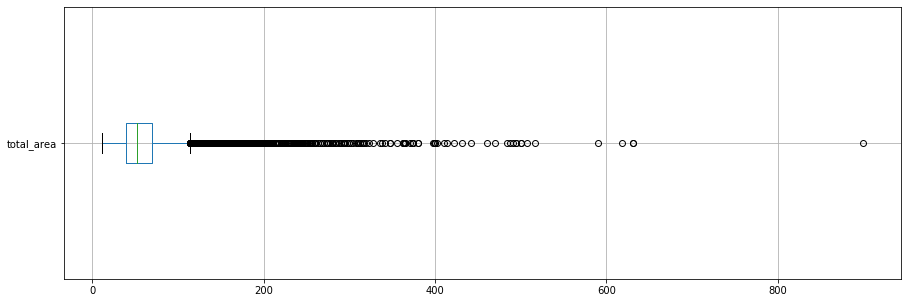

In [36]:
df.boxplot(column='total_area', vert=False, figsize=(15,5))

После 550 вижу единичные значения. Удалим

In [37]:
df = df[df['total_area'] < 550]
len(df)

23534

Построим графики снова

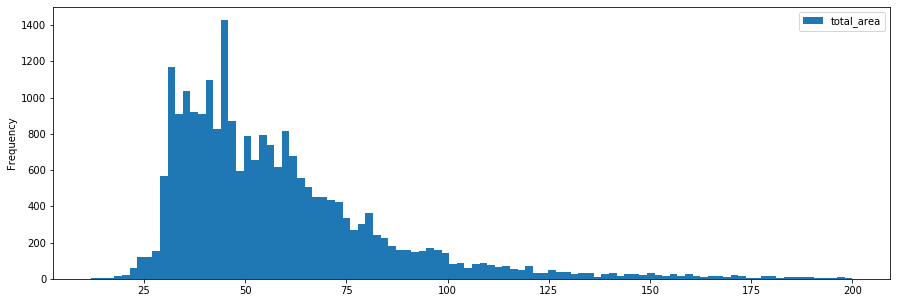

In [38]:
df['total_area'].plot(kind='hist', range=(12,200), label = 'total_area', bins = 100, legend=True, figsize=(15,5))


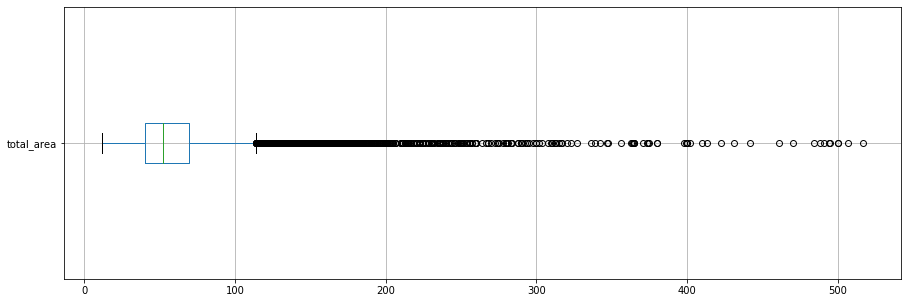

In [39]:
df.boxplot(column='total_area', vert=False, figsize=(15,5))

In [40]:
df['total_area'].describe()

count    23534.000000
mean        60.142616
std         34.285566
min         12.000000
25%         40.000000
50%         52.000000
75%         69.677500
max        517.000000
Name: total_area, dtype: float64

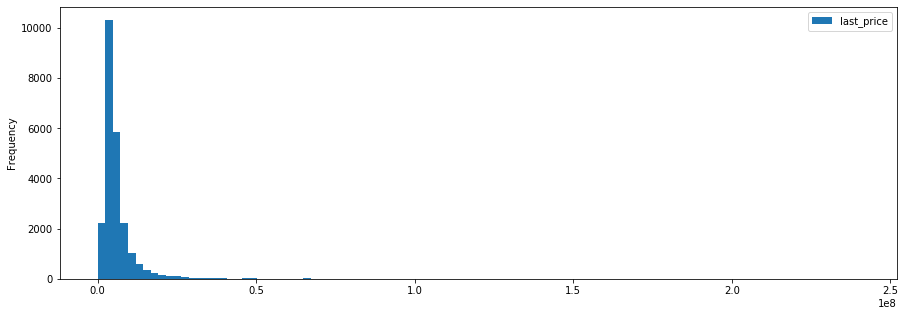

In [41]:
# last_price', 'rooms', 'ceiling_height
df['last_price'].plot(kind='hist', label = 'last_price', bins = 100, legend=True, figsize=(15,5))


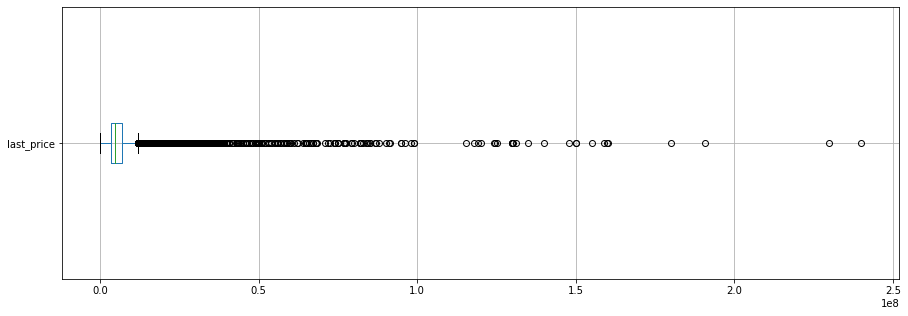

In [42]:
df.boxplot(column='last_price', vert=False, figsize=(15,5))

In [43]:
len(df[df['last_price']>100000000])

25

Уберем еединичные значения, чтобы не мешали выборке

In [44]:
df = df[df['last_price']<100000000]
len(df)

23509

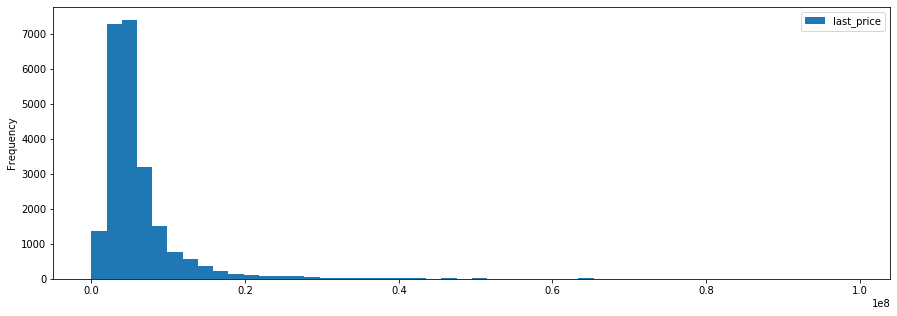

In [45]:
df['last_price'].plot(kind='hist', label = 'last_price', bins = 50, legend=True, figsize=(15,5))


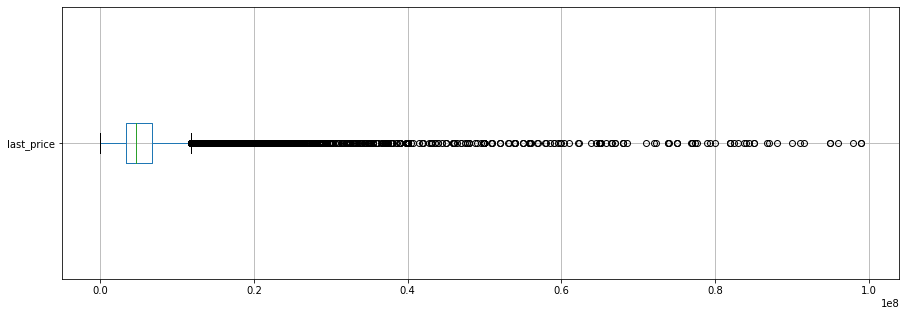

In [46]:
df.boxplot(column='last_price', vert=False, figsize=(15,5))

In [47]:
df['last_price'].describe().round()

count       23509.0
mean      6245158.0
std       6417714.0
min         12190.0
25%       3400000.0
50%       4625000.0
75%       6750000.0
max      99000000.0
Name: last_price, dtype: float64

<s><font color='red'>Очень хорошо, что используешь цикл для построения графика, но хотелось бы увидеть 
комментарии и выводы, что мы на них видим.</font>  </s>

Медианная площадь квартиры 60м. Минимальная 12, 75-й квартиль — 69м. 

Выбросы сильно выходят за 1.5 размаха межквартильного расстояния. Однако это не повод лишать себя данныъ по дорогим квартирам?

<font color='green'>В целом, твои аккуратные удаления наиболее выделяющихся данных вполне обоснованны.</font>

###### Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?


In [48]:

# df.pivot_table(index=['rooms'], values =['total_area', 'last_price', 'ceiling_height'], aggfunc =['count', 'mean', 'min', 'max'])
print(df['days_exposition'].min())
df['days_exposition'].max()/365


1.0


4.328767123287672

Минимальное время продажи квартиры — один день. Максимальное — 4 года и 4 месяца.

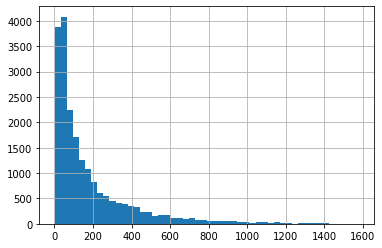

In [49]:
df['days_exposition'].hist(bins=50)
plt.show()

count    20348.000000
mean       180.554207
std        219.609643
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

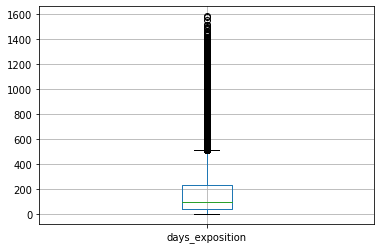

In [50]:
# df['days_exposition'].hist(bins=50)
# plt.show()

df.boxplot(column = 'days_exposition') 
df['days_exposition'].describe()

Медианное значение длительности продаж квартир — 95 дней. Основная масса продается от 45 до 232 дней. Максимум — 4.3 года

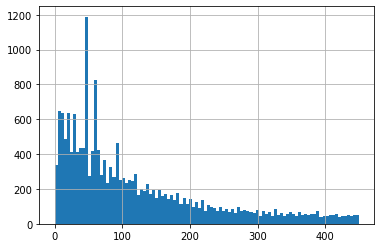

In [51]:
df['days_exposition'].hist(bins=100, range=(0,450))
plt.show()

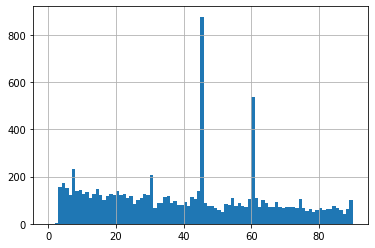

In [52]:
df['days_exposition'].hist(bins=90, range=(0,90))
plt.show()

Срок размещения в я недвижимости для МСК — 30 дней, для остальных регионов — 45. Вот с чем связаны выбросы — с закрытием объявлений в эти дни

<font color='brown'>Что это может значить? Стоит ли нам убрать эти данные из анализа? (Подсказка: проверь правила размещения объявлений в Яндекс.Недвижимости.  
<font color='blue'> Срок размещения в я недвижимости для МСК — 30 дней, для остальных регионов — 45. Вот с чем связаны выбросы — с закрытием объявлений в эти дни

In [53]:
# print(f'Среднее время продажи {df['days_exposition'].mean()}')
# print(f'Медиана времени продажи {df['days_exposition'].median()}')

print(df['days_exposition'].median())
print(df['days_exposition'].mean())

95.0
180.55420680165128


В основном квартиры продаются за 3 месяца. Среднее сдвинуто,  есть квартиры, которые продаются долго.  
Необычно быстро — такого нет , нормально, что квартира продается и за несколько дней.  
<font color='green'>Необычно долго — основная масса продается от 45 до 232 дней. Согласно boxplot верхний ус около 450 дней. Все, что продается дольше, можно считать необычно долгой продажей.

<font color='green'><b>Хорошо.</font>

<s><font color='red'>По быстрым все верно, но год - это твое субъективное суждение. А вдруг довольно много квартир продаются целый год? Попробуй найти выбросы с помощью boxplot.

Сгруппируем квартиры так —  
однокомнатные и студии
2 комнаты
3 комнаты
многокомнатные



In [54]:
def rooms(number):
    if number <= 1:
        return 'однокомнатные и студии'
    if number == 2:
        return 'Двухкомнатная'
    if number == 3:
        return 'Трехкомнатная'
    if number == 4:
        return 'Четырехкомнатная'    
    return 'Многокомнатная'

df['how_much_rooms'] = df['rooms'].apply(rooms)
df['how_much_rooms'].value_counts()

однокомнатные и студии    8188
Двухкомнатная             7892
Трехкомнатная             5771
Четырехкомнатная          1163
Многокомнатная             495
Name: how_much_rooms, dtype: int64

Квартир с числом комнат больше 4 мало

<font color='green'>Тут все хорошо.

<s><font color='red'>Хорошие рассуждения, четкие срезы. Есть одно но, строя срезы, мы где-то потеряли больше половины данных. Это слишком много, надо найти.</font>

###### Какие факторы больше всего влияют на стоимость квартиры?   
Изучите, зависит ли цена от квадратного метра, числа комнат, удалённости от центра.   
Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом.   
Также изучите зависимость от даты размещения: дня недели, месяца и года.


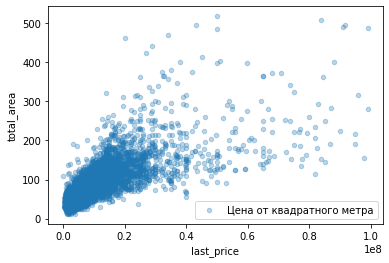

In [55]:
df.plot(x='last_price', y='total_area', kind='scatter', alpha=0.3, label='Цена от квадратного метра')

В основном сегменте рынка цена сильно зависит от метража. Дорогие квартиры однако могут быть небольшой площади также

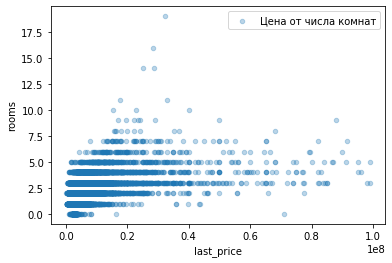

In [56]:
df.plot(x='last_price', y='rooms', kind='scatter', alpha=0.3, label='Цена от числа комнат')


Зависимость наблюдается! Многокомнатные квартиры в основном в дорогом сегменте. Есть впечатление, что свыше 10 комнат — выбросы — они в среднем ценвом сегменте. А может это какие-то заброшенные дома

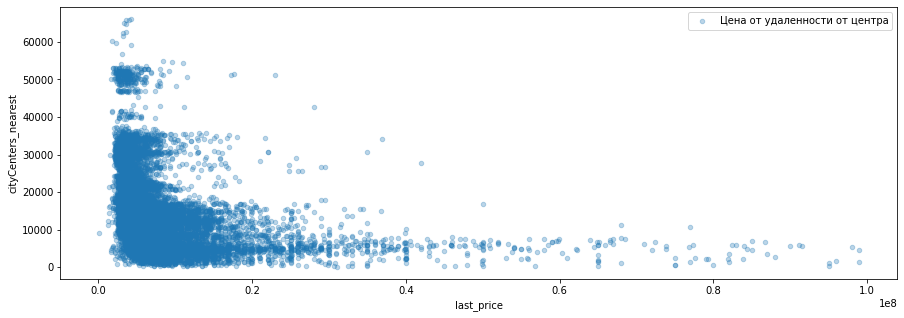

In [57]:
df.plot(x='last_price', y='cityCenters_nearest', kind='scatter', alpha=0.3, figsize=(15,5), label='Цена от удаленности от центра')


В центре города есть как дорогое, так и дешевое жилье. А вот в отдалении цена явно падает.

<s><font color='red'>Хорошо было бы показать и проанализировать значения корреляции у этих пар параметров.</font>

In [58]:
print(df['last_price'].corr(df['cityCenters_nearest']))


-0.2995277981719185


Кореляция слабая, видимо из-за того, что в центре присутствует и дорогое и дешевое жилье. Проверим гипотезу

<font color='blue'> Отрицательная корреляция тоже может быть сильной, она указывает на обратную зависимость между переменными. Ведь, чем МЕНЬШЕ расстояние до центра, тем ВЫШЕ цена на недвижимость. Что и показывает данная цифра. 0.30 это не то, чтобы сильная корреляция, онака она определенно значимая.</font>

In [59]:
print(df['last_price'].corr(df['cityCenters_nearest']<10000))


0.42258052630689324


Прии удалении от центра цена явно падает. В центре при этом есть как дорогие, так и дешевые квартиры. 

<font color='blue'>Наверное, ты имел в виду это:

In [60]:
print(df['last_price'].corr(df[df['cityCenters_nearest']<10000]['cityCenters_nearest']))

-0.21365095329874648


<font color='blue'>На периферии тоже обратная зависимость, однака уже не такая сильная, как в центре.

<s><font color='red'>+Как это нет, корреляция принимает значения от -1 до 1, и -0.3 это вполне себе коррелляция. Изучи этот момент и напиши вывод, как цена зависит от удалености от центра.</font>

<s><font color='red'>Давай искать зависимость от даты размещения: сгруппируем в сводной таблице данные по, например, месяцу и посмотрим медианные значения для каждого месяца. Эти данные уже выведем на график, обычный plot. Так же поступим с остальными параметрами.

###### зависимость цены от того, на каком этаже расположена квартира

(4000000, 7000000)

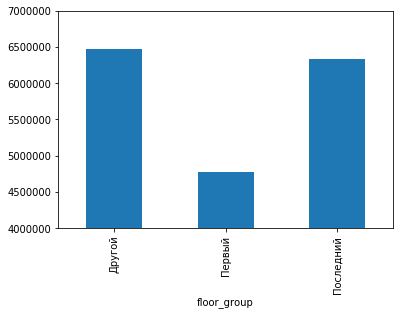

In [61]:
df.groupby('floor_group')['last_price'].agg('mean').plot(kind='bar')
plt.ylim(4000000, 7000000)

На первом этаже цена квартиры ниже в среднем на 1.6 млн, на последнеем — на 140 тысяч

In [62]:
df.groupby('floor_group')['last_price'].agg('mean').round()

floor_group
Другой       6473765.0
Первый       4777628.0
Последний    6327135.0
Name: last_price, dtype: float64

###### Цена в зависимости от месяца размещения

(5750000, 6750000)

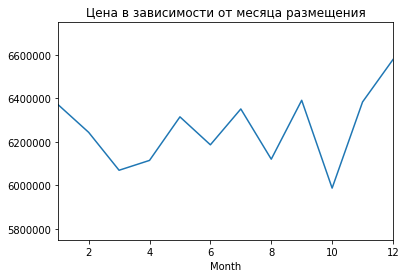

In [63]:
df.groupby('Month')['last_price'].agg('mean').plot(title='Цена в зависимости от месяца размещения')
plt.ylim(5750000, 6750000)

<font color='brown'>Не очень наглядно - попробуй вывести значения по оси y начиная с 4-5 млн. И еще, в подобных случаях лучше подходят графики вида line.</font>  
<font color='green'> Приблизил значения и сделал line. И правда нагляднее!

Самая низкая цена в ноябре, в декабре и январе цена выше, чем в остальные месяцы ~ на 500 тысяч.

###### Цена в зависимости от года размещения

(5000000, 13000000)

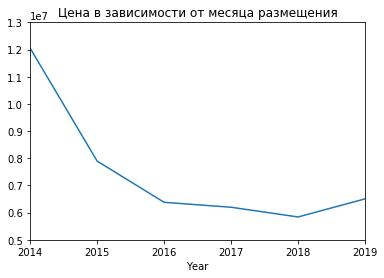

In [64]:
df.groupby('Year')['last_price'].agg('mean').plot(title='Цена в зависимости от месяца размещения')
plt.ylim(5000000, 13000000)

Да, после 2014 цены на квартиры упали вместе с доходами(

###### Цена в зависимости от дня недели размещения

(6000000, 6600000)

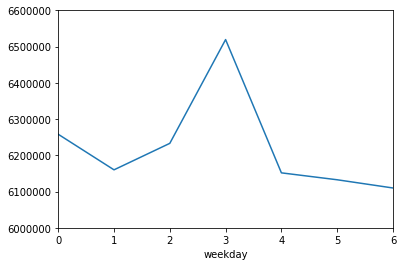

In [65]:
df.groupby('weekday')['last_price'].agg('mean').plot(label='Цена в зависимости от месяца размещения')
plt.ylim(6000000, 6600000)

В среду цена чуть выше, дельта составляет до 400 тысяч!

<font color='green'>По умолчанию это среда. Здесь тоже можно понагляднее сделать, отрегулировав масштаб.</font>

###### Выберите 10 населённых пунктов с наибольшим числом объявлений.  
Посчитайте среднюю цену квадратного метра в этих населённых пунктах.   
Выделите населённые пункты с самой высокой и низкой стоимостью жилья.

In [66]:
large_cities = df.pivot_table(index=['locality_name'], 
                                            values= 'sq_meter_cost',
                                            aggfunc =['count', 'mean'])

large_cities.columns = ['count', 'sq_meter_cost']
ten_cities = large_cities.sort_values(by='count', ascending=False).head(10).round(0)
ten_cities = ten_cities.sort_values(by='sq_meter_cost', ascending=False)
ten_cities

,count,sq_meter_cost
locality_name,,
санкт-петербург,15605,113488.0
пушкин,369,103126.0
деревня кудрово,299,92474.0
посёлок парголово,327,90176.0
посёлок мурино,520,85673.0
посёлок шушары,439,78551.0
колпино,338,75425.0
гатчина,307,68746.0
всеволожск,397,68719.0


###### Самая высокая стоимость жилья

In [67]:
ten_cities.sort_values(by='sq_meter_cost', ascending=False).head(1)

,count,sq_meter_cost
locality_name,,
санкт-петербург,15605,113488.0


###### Самая низкая стоимость жилья

In [68]:
ten_cities.sort_values(by='sq_meter_cost', ascending=True).head(1)

,count,sq_meter_cost
locality_name,,
выборг,235,58238.0


###### Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра.   
+Выделите квартиры в Санкт-Петербурге ('locality_name').   
Ваша задача — выяснить, какая область входит в центр.   
Создайте столбец с расстоянием до центра в километрах: округлите до целых значений.   
После этого посчитайте среднюю цену для каждого километра.   
Постройте график: он должен показывать, как цена зависит от удалённости от центра.   
Определите границу, где график сильно меняется — это и будет центральная зона.


In [69]:
saint_pt = df.query('locality_name == "санкт-петербург"')
# saint_pt = df[frequent_numbers['locality_name'] == 'санкт-петербург']
saint_pt['cityCenters_km'] = (saint_pt['cityCenters_nearest'] / 1000).round()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
km_vs_price = saint_pt.pivot_table(index = 'cityCenters_km', values = 'sq_meter_cost', aggfunc = 'mean')

In [71]:
# km_vs_price.index = km_vs_price.index.astype(int) #use astype to convert to int

km_vs_price = km_vs_price.reset_index()



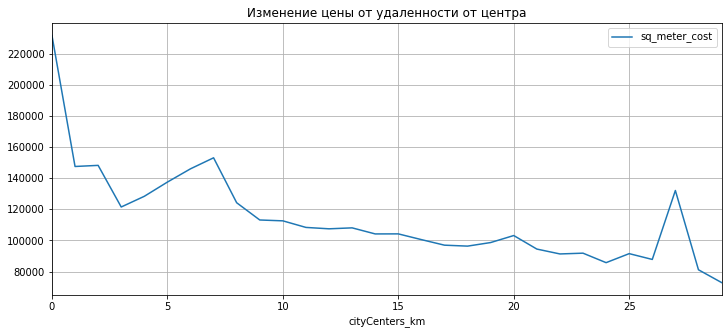

In [72]:
km_vs_price.plot(x='cityCenters_km', y='sq_meter_cost',style='-', alpha=1, figsize = (12,5), grid=True, title='Изменение цены от удаленности от центра')
plt.show()
# km_vs_price.info()

Судя по графику, центр — до одного км, дальше цена сильно ниже. 

<s><font color='red'>+Один километр явно маловато для Питера. Давай возьмем за основу падение цены на 7-м км.</font>

Ок! Берем 7 км, дальше график падает.

###### Выделите сегмент квартир в центре.  
Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков.  
Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). 
Сделайте выводы. Отличаются ли они от общих выводов по всему городу?


In [73]:
saint_pt_centr = saint_pt.query('cityCenters_km <= 7')
saint_pt_centr.describe().round(2)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,Year,Day,weekday,Month,living_vs_total_area,cityCenters_km
count,3480.00,3480.00,3480.00,3480.00,3480.00,3480.00,3192.00,3480.00,3153.00,3480.00,...,3480.00,2517.00,2905.00,3480.00,3480.00,3480.00,3480.00,3480.00,3192.00,3480.00
mean,10.16,13132271.62,90.79,2.81,3.01,7.11,53.33,4.19,14.28,0.32,...,1.29,465.68,246.82,139669.14,2017.17,15.58,2.51,6.44,0.58,4.51
std,5.99,12332672.38,53.38,1.42,0.59,3.86,34.74,2.95,8.68,0.76,...,1.09,271.60,273.57,66809.72,1.12,8.62,1.72,3.46,0.12,1.68
min,0.00,1600000.00,12.00,0.00,2.40,2.00,2.00,1.00,2.00,0.00,...,0.00,22.00,3.00,15345.27,2014.00,1.00,0.00,1.00,0.02,0.00
25%,6.00,6650000.00,56.70,2.00,2.75,5.00,31.00,2.00,9.00,0.00,...,0.00,228.00,60.00,99702.38,2017.00,9.00,1.00,3.00,0.51,4.00
50%,10.00,9055000.00,78.00,3.00,2.96,6.00,45.50,4.00,12.00,0.00,...,1.00,457.00,140.00,123002.44,2017.00,16.00,3.00,6.00,0.60,5.00
75%,15.00,14000000.00,108.72,3.00,3.13,9.00,65.50,5.00,16.70,0.00,...,2.00,667.00,346.00,154500.00,2018.00,23.00,4.00,10.00,0.66,6.00
max,50.00,99000000.00,517.00,19.00,32.00,25.00,347.50,25.00,107.00,5.00,...,3.00,1293.00,1572.00,721518.99,2019.00,31.00,6.00,12.00,0.98,7.00


В скобках укажу цифры в общем по таблице
###### площадь  
Средняя площадь — 90(60), медиана — 78(52). Квартиль 25% — 56(40) метров. 
###### цена
Средняя цена сделки — 13(6.5) млн

###### Число комнат
В среднем — 3(2) комнаты

###### Высота потолков
— среднее 3(2.7) метра. 

Жилье в центре больше и дороже, чем в общем по таблице.

<font color='green'> Хорошо.

In [74]:
df.describe().round(2)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,Year,Day,weekday,Month,living_vs_total_area
count,23509.00,23509.00,23509.00,23509.00,23509.00,23509.00,21653.00,23509.00,21297.00,23509.00,...,7997.00,18019.00,8995.00,20348.00,23509.00,23509.00,23509.00,23509.00,23509.00,21653.00
mean,9.87,6245157.74,59.89,2.07,2.75,10.68,34.23,5.88,10.51,0.59,...,490.95,0.77,519.24,180.55,98478.06,2017.37,15.48,2.57,6.40,0.56
std,5.68,6417714.31,33.29,1.07,0.62,6.59,21.04,4.87,5.71,0.96,...,342.03,0.94,277.93,219.61,42395.59,1.04,8.63,1.79,3.49,0.11
min,0.00,12190.00,12.00,0.00,2.20,1.00,2.00,1.00,1.30,0.00,...,1.00,0.00,13.00,1.00,111.83,2014.00,1.00,0.00,1.00,0.02
25%,6.00,3400000.00,40.00,1.00,2.60,5.00,18.60,2.00,7.00,0.00,...,288.00,0.00,295.00,45.00,76556.02,2017.00,8.00,1.00,3.00,0.50
50%,9.00,4625000.00,52.00,2.00,2.71,9.00,30.00,4.00,9.10,0.00,...,455.00,0.00,503.00,95.00,94936.71,2017.00,15.00,3.00,6.00,0.57
75%,14.00,6750000.00,69.50,3.00,2.78,16.00,42.20,8.00,12.00,1.00,...,612.00,1.00,732.00,231.00,114062.50,2018.00,23.00,4.00,10.00,0.64
max,50.00,99000000.00,517.00,19.00,32.00,60.00,347.50,33.00,107.00,5.00,...,3190.00,3.00,1344.00,1580.00,721518.99,2019.00,31.00,6.00,12.00,1.00


###### Выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). 


In [75]:
saint_pt_centr_4_columns = saint_pt_centr[['last_price', 'rooms', 'total_area', 'floor', 'cityCenters_km', 'days_exposition']]

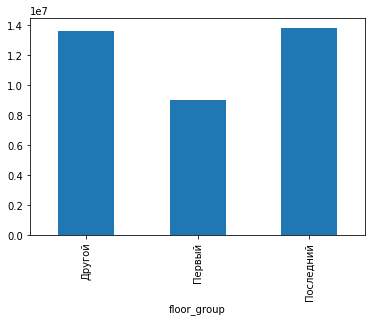

In [76]:
saint_pt_centr.groupby('floor_group')['last_price'].agg('mean').plot(kind='bar')

+<font color='blue'>А вот здесь, как по мне, bar выглядит нагляднее, всего три точки - для линейного графика маловато.</font>

В центре не любят первый этаж, а последний столь же популярен, как и остальные.

<font color='blue'>В целом это нормальное явление.</font>

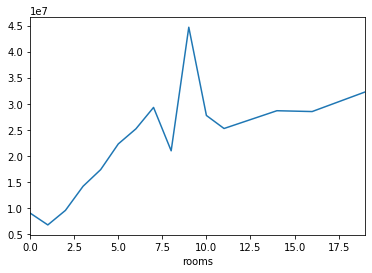

In [77]:
saint_pt_centr.groupby('rooms')['last_price'].agg('mean').plot()

С увеличением комнат цена растет

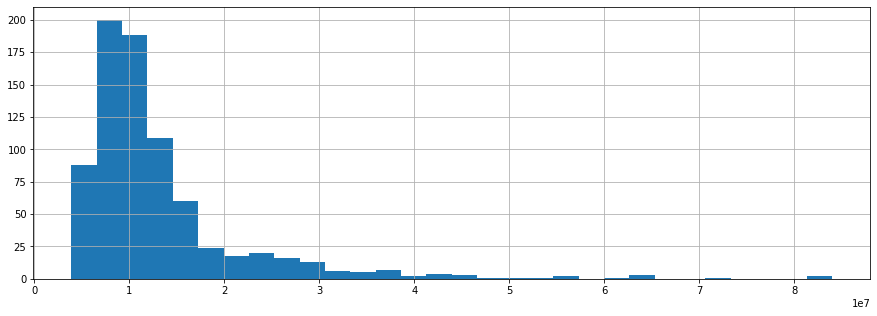

In [78]:
saint_pt_centr.groupby('days_exposition')['last_price'].agg('mean').hist(bins=30, figsize=(15,5))

<s><font color='red'>Куда же делись циклы? Мы должны строить однотипные графики в циклах. </font>  

<font color='green'>Мне не нравится — они получаются в маленьком окне и надо пролистывать, нельзя под каждым писать комментарий. Как расположить по два графика в строке — слева и справа? Вроде нашел share=True, попробую в будущем

<font color='blue'> Можно использовать plt.subplots, но это выходит за рамки проекта.

С увеличением цены растет и время продажи.

+<font color='brown'>Такой график дает не очень наглядную информацию. Попробуй снова вывести линейные графики со средними ценами в зависимости от этажа, километров от центра и т.д.  
  
+Обязательно сравни результаты по центру Питера с общими результатами.</font>

<s><font color='red'>+Также посмотри корреляционную матрицу, можешь ее визуализировать с помощью seaborn.

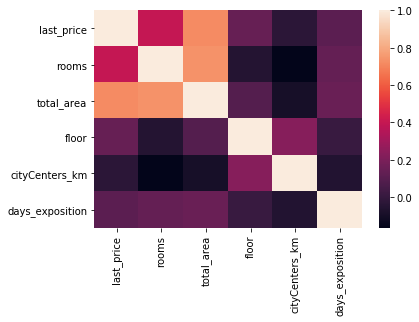

In [79]:
import seaborn as sns

corr = saint_pt_centr_4_columns.corr()
figsize=(10, 8)
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)



На графике:  
1. Самая сильная зависимость — от общей площади.
2. Затем — количество комнат
3. Этаж и количество дней экспозиции
4. Удаленность от центра. 

###### Сравним с общей по таблице.

In [80]:
df_4_columns = df[['last_price', 'rooms', 'total_area', 'floor', 'cityCenters_nearest', 'days_exposition']]

,last_price,rooms,total_area,floor,cityCenters_nearest,days_exposition
last_price,1.000000,0.470481,0.768823,0.037016,-0.299528,0.123396
rooms,0.470481,1.000000,0.767976,-0.154111,-0.180313,0.126333
total_area,0.768823,0.767976,1.000000,-0.028637,-0.232384,0.153896
floor,0.037016,-0.154111,-0.028637,1.000000,0.007434,-0.038529
cityCenters_nearest,-0.299528,-0.180313,-0.232384,0.007434,1.000000,-0.057860
days_exposition,0.123396,0.126333,0.153896,-0.038529,-0.057860,1.000000


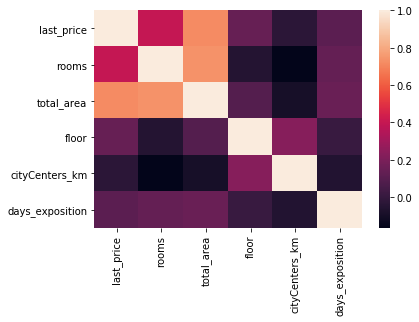

In [81]:
corr_df = df_4_columns.corr()
figsize=(10, 8)
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr_df

total_area           AxesSubplot(0.125,0.536818;0.352273x0.343182)
last_price        AxesSubplot(0.547727,0.536818;0.352273x0.343182)
rooms                   AxesSubplot(0.125,0.125;0.352273x0.343182)
ceiling_height       AxesSubplot(0.547727,0.125;0.352273x0.343182)
dtype: object

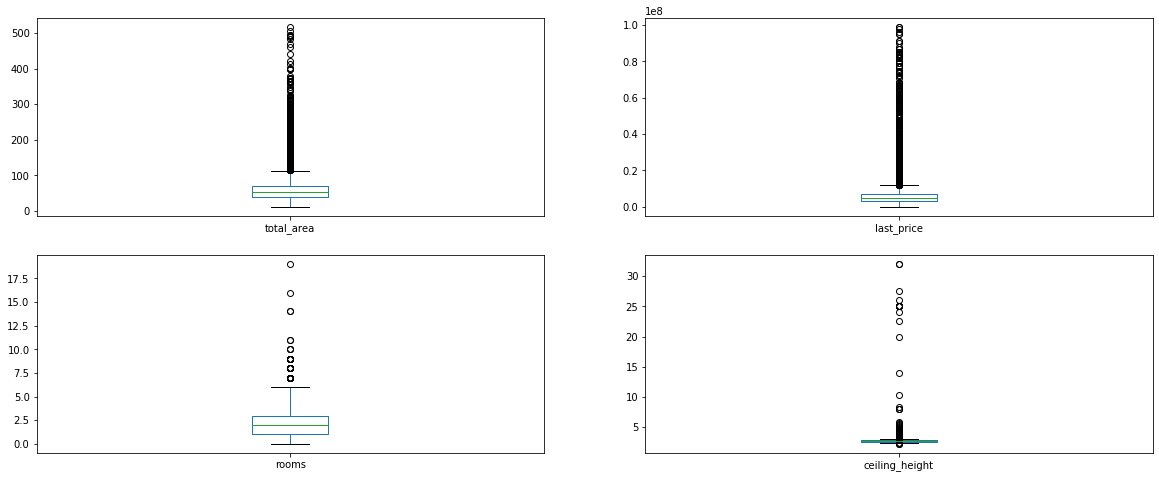

In [84]:
column_list1 = ['total_area', 'last_price', 'rooms', 'ceiling_height']
df[column_list1].plot(kind='box', subplots=True, layout=(2,2), figsize=(20,8))

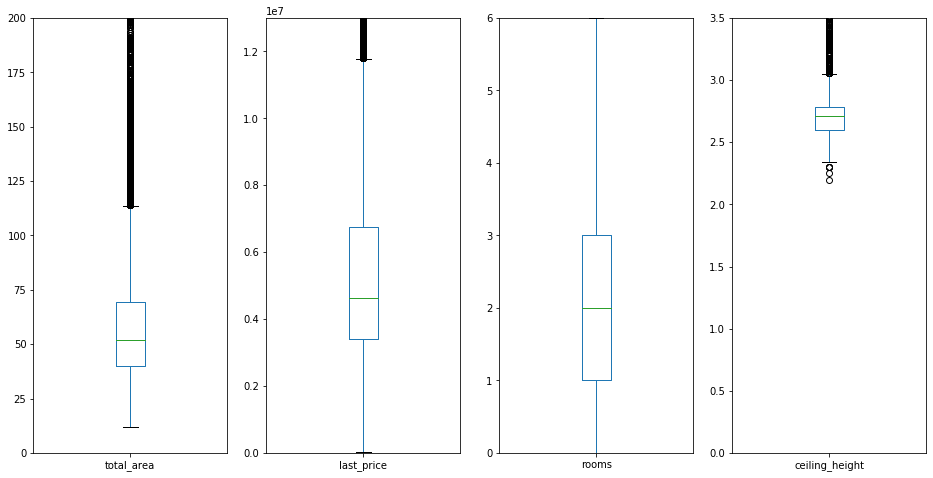

In [98]:
column_list1 = ['total_area', 'last_price', 'rooms', 'ceiling_height']
ax = df[column_list1].plot(kind='box', subplots=True, layout=(1,4), figsize=(16,8))
ylims = [200, 13000000, 6, 3.5]
for i in range(len(column_list1)):
    ax[column_list1[i]].set_ylim(0, ylims[i])
# ^^^ этот цикл равнозначен тому, что ниже:
# ax['total_area'] = set_ylim(0, 600)
# ax['last_price'] = set_ylim(0, 13000000)
# ax['rooms'] = set_ylim(0, 10)
# ax['ceiling_height'] = set_ylim(0, 5)

<IPython.core.display.Javascript object>


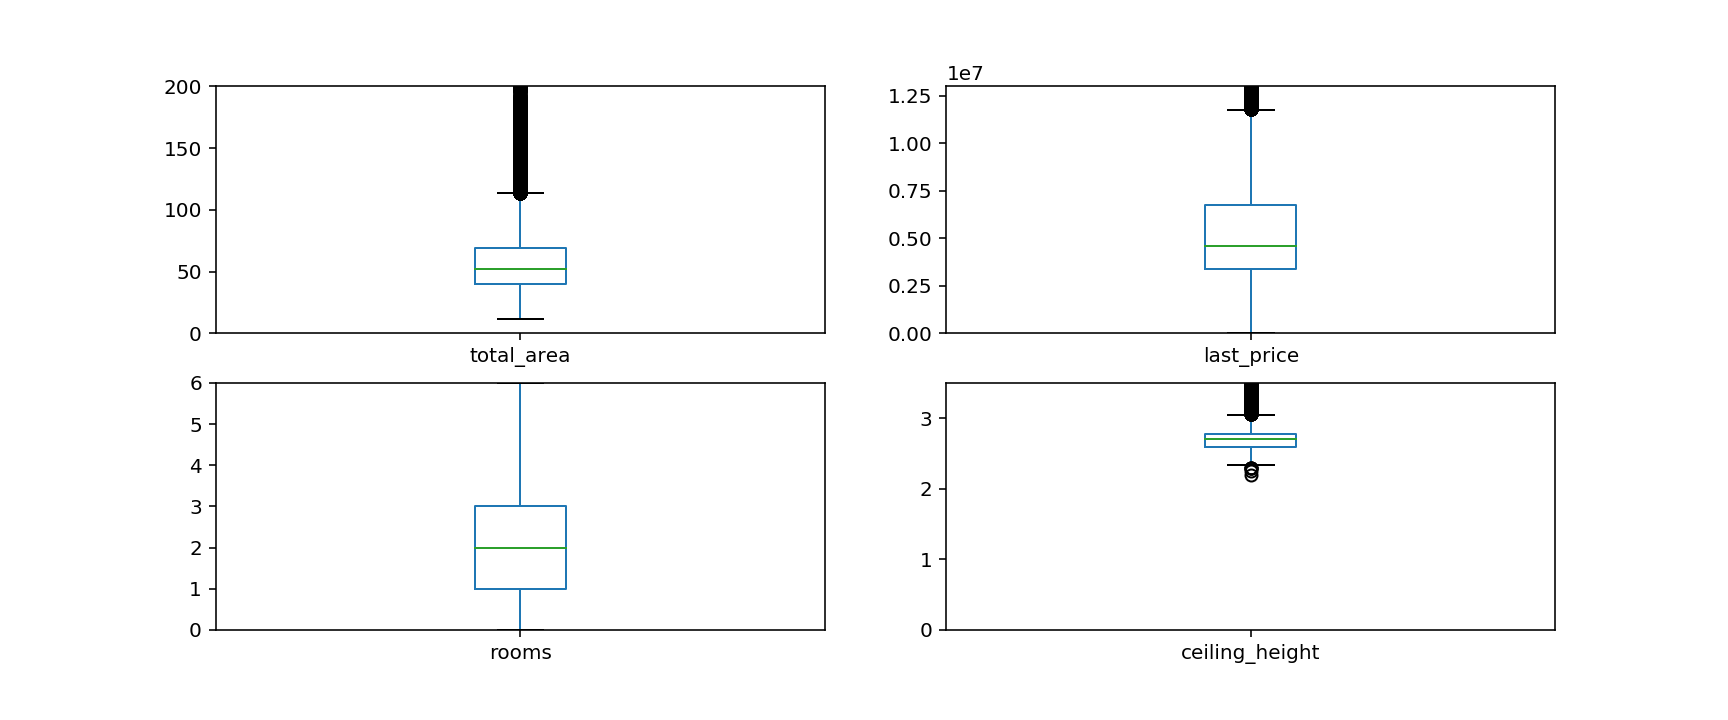

In [106]:
%matplotlib notebook
column_list1 = ['total_area', 'last_price', 'rooms', 'ceiling_height']
ax = df[column_list1].plot(kind='box', subplots=True, layout=(2,2), figsize=(12,5))
ylims = [200, 13000000, 6, 3.5]
for i in range(len(column_list1)):
    ax[column_list1[i]].set_ylim(0, ylims[i])

В общем по таблице корреляция таже самая. 

Цена растет вплоть с уыеличением комнат.
Меньше всего спрос на первый этаж.
Самые дорогие единичные квартиры 1 - 2 км от центра. Но похоже квартиры подальше — 6-7 км популярнее.
Дешевые и квартиры в среднем сегменте в основном продаются до 200 дней. Квартиры стоимостью свыше миллиарда продаются до двух лет.

<font color='green'>Хорошо, корреляцию засчитываем.</font>

# Шаг 5. Общий вывод

###### Обработка данных
Некоторые данные пропущены. Балконы заменил 0 — отсутствие. Пропуски по этажам — средним значением по группе домов с той же этажностью
Строки приведены к нижнему регистру, заменены значения на int где нужно. 
Убрал единичные значения выбросов, которые были видны на boxplot — например, потолки 100 метров.
Выбросы по дорогим квартирам наверное можно было бы оставить . Там всего несколько значений — убрал для наглядности графиков

Добавил в таблицу цену квадратного метра;
день недели, месяц и год публикации объявления;
этаж квартиры; варианты — первый, последний, другой;
соотношение жилой и общей площади, а также отношение площади кухни к общей.

###### Выводы
Обнаружил выбросы по закрытию объявлений в период кратный 15 дням после месяца публикаций. (связано с публикацие обяъвленицй в мск на месяц и по другим регионам — 45 дней)

основная масса продается от 45 до 232 дней 
Все, что продается дольше 450 дней можно считать необычно долгой продажей.

В основном сегменте рынка цена сильно зависит от метража, удаления от центра.

На первом этаже цена квартиры ниже в среднем на 1.6 млн, на последнеем — на 140 тысяч

В декабре и январе цена незначительно выше, чем в остальные месяцы

После 2014 цены на квартиры упали — с 12 млн до 6 млн в среднем

Самая высокая стоимость жилья — в СПБ (113 т за кв м). Самая низкая — в Выборге (58 т за кв м)

Отличия квартир в центре СПБ и в среднем по таблице

В скобках укажу цифры в общем по таблице  
Средняя площадь — 104(60), медиана — 90(52). Квартиль 25% — 69(40) метров.   
Средняя цена сделки — 17.5(6.5 млн) млн  
В среднем в квартире  — 3(2) комнаты  

Высота потолков — 3(2.7) метра. 

В центре последний этаж стоит как первый. А в общем по таблице первый дешевле последнего.

С увеличением цены растет и время продажи. — ***это положительная кореляция, когда оба параметра растут в одну сторону***

<font color='green'>Подробные выводы - хорошо поработал!</font>

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод

<font color='blue'>В целом, неплохое начало. Хороший вывод графиков в цикле, хорошее применение знаний из прошлого спринта. Многое сделано, кое-что закончено, остальное доделаем в ходе доработок. Удачи!</font>  

<font color='green'> Спасибо!

<font color='blue'>Двигаемся вперед, отлично. Но еще есть над чем поработать, ищи красные комментарии. </font>

<font color='green'>Пока что у меня вызывают трудность технические методы, довольно долго думаю, как решить тот или иной параметр — увеличить график, тип, добавить в столбец и тп. Я чувствую, что из-за этого упускаю статистику, мог бы эффективнее оценивать, если бы свободно себя чувствовал в pandas. С другой стороны, прошло всего 18 дней занятий. Вроде неплохой прогресс. Но и времени и сил уходит много. 

Напишете, что видно со стороны? &#128520;</font>

<font color='blue'>Это все более, чем нормально, с каждым разом будет все легче и легче. Прогресс безусловно заметен. Работай в комфортном темпе, из твоей группы еще почти никто не сдавал второй проект, так что мы можем не спешить, сделать техническую часть, после чего спокойно поразмышлять над аналитикой.  
Эти работы действительно довольно сложные и рассчитаны на усердную работу, но они максимально приближены к реальной жизни, и, пройдя такую школу в работе будет гораздо легче.  
В целом ты прекрасно справляешься. 

Спасибо за рецензию!

<font color='blue'> Насчет работы, мы почти справились, осталось разобраться с пропусками. Ну а также я настоятельно рекомендую еще раз почитать про корреляцию, ++разобраться с положительной/отрицательно корреляцией и написать выводы с учетом этого.

<font color='blue'>Итак. Ты продемонстрировал достаточно знаний и умений, чтобы я принял работу. Проанализировал, очистил и обогатил данные. Построил множество разнообразных графиков, обнаружил и удалил выбросы. Также мы выяснили, как влияют на цену различные факторы, делали срезы и сравнивали результаты.  
Напоследок я все же порекомендую поподробнее почитать/спросить по корреляцию, это знание будет жизненно необходимо. Не бойся сложностей, удачи в дальнейшем прохождении курса!